<a href="https://colab.research.google.com/github/khairulomar/Melbourne_pedestrian/blob/master/Melbourne_pedestrian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [243]:
pip install sodapy

In [0]:
import pandas as pd
import numpy as np
import math
import datetime as dt
from sodapy import Socrata
import progressbar
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing

# Investigate overall data

In [245]:
# Import data from API

client = Socrata('data.melbourne.vic.gov.au',
                 'rU9dviaJKpt9U9Mk9aPFFOIvS',
                 'khairul@yahoo.com',
                 'KhairulMaps2019&')

# To begin, download all data but limit to only for monday noons for overview
results = client.get("b2ak-trbp", day='Monday', time=12, limit=50000)

dfraw0 = pd.DataFrame.from_records(results)
display(len(dfraw0))
display(dfraw0.head())

17822

,id,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts
0,2891212,2019-11-04T12:00:00.000,2019,November,4,Monday,12,4,Town Hall (West),4535
1,2891213,2019-11-04T12:00:00.000,2019,November,4,Monday,12,17,Collins Place (South),1145
2,2891214,2019-11-04T12:00:00.000,2019,November,4,Monday,12,18,Collins Place (North),421
3,2891215,2019-11-04T12:00:00.000,2019,November,4,Monday,12,53,Collins St (North),2570
4,2891216,2019-11-04T12:00:00.000,2019,November,4,Monday,12,2,Bourke Street Mall (South),5227


In [247]:
# First round of cleaning
df = dfraw0.copy()
df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = df['date_time'].dt.date
df['year'] = df['year'].astype('int')
df['hourly_counts'] = df['hourly_counts'].astype('int')
df['sensor'] = df['sensor_id'].map(lambda row: '0'+str(row) if int(row)<10 else row) + " : " + df['sensor_name']
df['sensor_id'] = df['sensor_id'].astype('int')
df.dtypes

id                       object
date_time        datetime64[ns]
year                      int64
month                    object
mdate                    object
day                      object
time                     object
sensor_id                 int64
sensor_name              object
hourly_counts             int64
date                     object
sensor                   object
dtype: object

In [248]:
# Convert to pivot for plotting
table = pd.pivot_table(df, values='hourly_counts', index='date',
                       columns='sensor', aggfunc=np.sum)
table.head(2)

sensor,01 : Bourke Street Mall (North),02 : Bourke Street Mall (South),03 : Melbourne Central,04 : Town Hall (West),05 : Princes Bridge,06 : Flinders Street Station Underpass,07 : Birrarung Marr,08 : Webb Bridge,09 : Southern Cross Station,10 : Victoria Point,11 : Waterfront City,12 : New Quay,13 : Flagstaff Station,14 : Sandridge Bridge,15 : State Library,16 : Australia on Collins,17 : Collins Place (South),18 : Collins Place (North),19 : Chinatown-Swanston St (North),20 : Chinatown-Lt Bourke St (South),21 : Bourke St-Russell St (West),22 : Flinders St-Elizabeth St (East),23 : Spencer St-Collins St (South),24 : Spencer St-Collins St (North),25 : Melbourne Convention Exhibition Centre,26 : QV Market-Elizabeth St (West),27 : QV Market-Peel St,28 : The Arts Centre,29 : St Kilda Rd-Alexandra Gardens,30 : Lonsdale St (South),31 : Lygon St (West),32 : City Square,33 : Flinders St-Spring St (West),34 : Flinders St-Spark La,35 : Southbank,36 : Queen St (West),37 : Lygon St (East),38 : Flinders St-Swanston St (West),39 : Alfred Place,40 : Lonsdale St-Spring St (West),41 : Flinders La-Swanston St (West),42 : Grattan St-Swanston St (West),43 : Monash Rd-Swanston St (West),44 : Tin Alley-Swanston St (West),45 : Little Collins St-Swanston St (East),46 : Pelham St (S),46 : Pelham St (South),47 : Melbourne Central-Elizabeth St (East),48 : QVM-Queen St (East),49 : QVM-Therry St (South),50 : Faraday St-Lygon St (West),51 : QVM-Franklin St (North),52 : Elizabeth St-Lonsdale St (South),53 : Collins St (North),54 : Lincoln-Swanston (West),54 : Lincoln-Swanston(West),55 : Elizabeth St-La Trobe St (East),56 : Lonsdale St - Elizabeth St (North),57 : Bourke St Bridge,58 : Bourke St - Spencer St (North),59 : Swanston St - RMIT Building 80,60 : Flinders La - Swanston St (West) Temp,60 : Flinders la - Swanston St (West) Temp,61 : Swanston St - RMIT Building 14,62 : La Trobe St (North),63 : 231 Bourke St,64 : Royal Pde-Grattan St
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-05-04,3532.0,2761.0,NaN,3789.0,1492.0,1931.0,NaN,NaN,808.0,529.0,93.0,267.0,1130.0,529.0,1829.0,2733.0,1442.0,722.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-05-11,3246.0,2483.0,NaN,3434.0,1269.0,1874.0,NaN,NaN,752.0,477.0,182.0,343.0,1097.0,602.0,1742.0,2552.0,1526.0,782.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


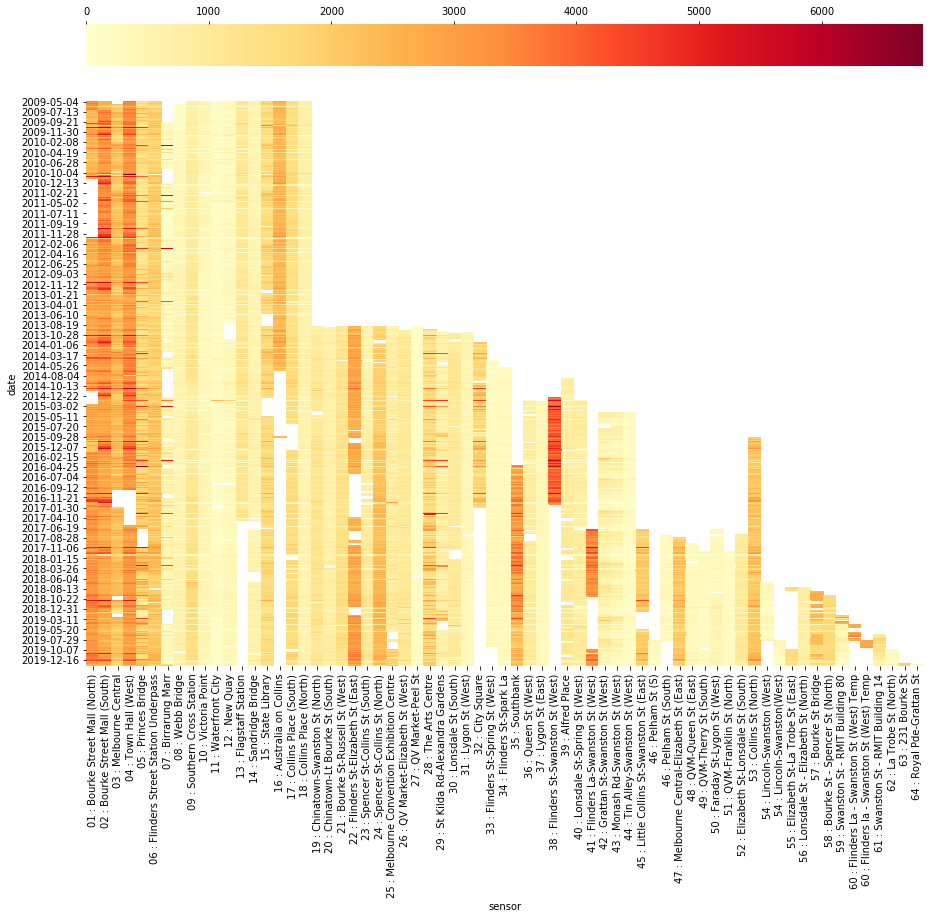

In [249]:
# Plot all available data, sampling at Monday noon only
fig, ax = plt.subplots(figsize=(15,13))
ax = sns.heatmap(table, cbar_kws = dict(use_gridspec=False,location="top"), cmap='YlOrRd')
plt.show()

# Shortlist sensor locations and period

In [250]:
# Group sensor locations based on availability of data

from google.colab import drive
drive.mount('/content/drive')

sensor_master = pd.read_excel('/content/drive/My Drive/Melb_project/CBD_grid.xlsx', sheet_name='master')
sensor_master = sensor_master.iloc[:,:8]
sensor_master.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,sensor_id,sensor_description,installation_date,CBD,Train_data,Test_data,x,y
0,1,Bourke Street Mall (North),2009-03-24,1,1,1,NaN,NaN
1,2,Bourke Street Mall (South),2009-03-30,1,1,1,NaN,NaN
2,3,Melbourne Central,2009-03-25,1,1,1,NaN,NaN
3,4,Town Hall (West),2009-03-23,1,1,1,NaN,NaN
4,5,Princes Bridge,2009-03-26,1,1,1,NaN,NaN


In [251]:
# List of sensor for training and test data
sensors = list(sensor_master[sensor_master['CBD']==1].sensor_id)
sensors_train_test = list(sensor_master[sensor_master['Train_data']==1].sensor_id)
sensors_test = list(sensor_master[(sensor_master['Train_data']==0)&sensor_master['Test_data']==1].sensor_id)
len(sensors)

39

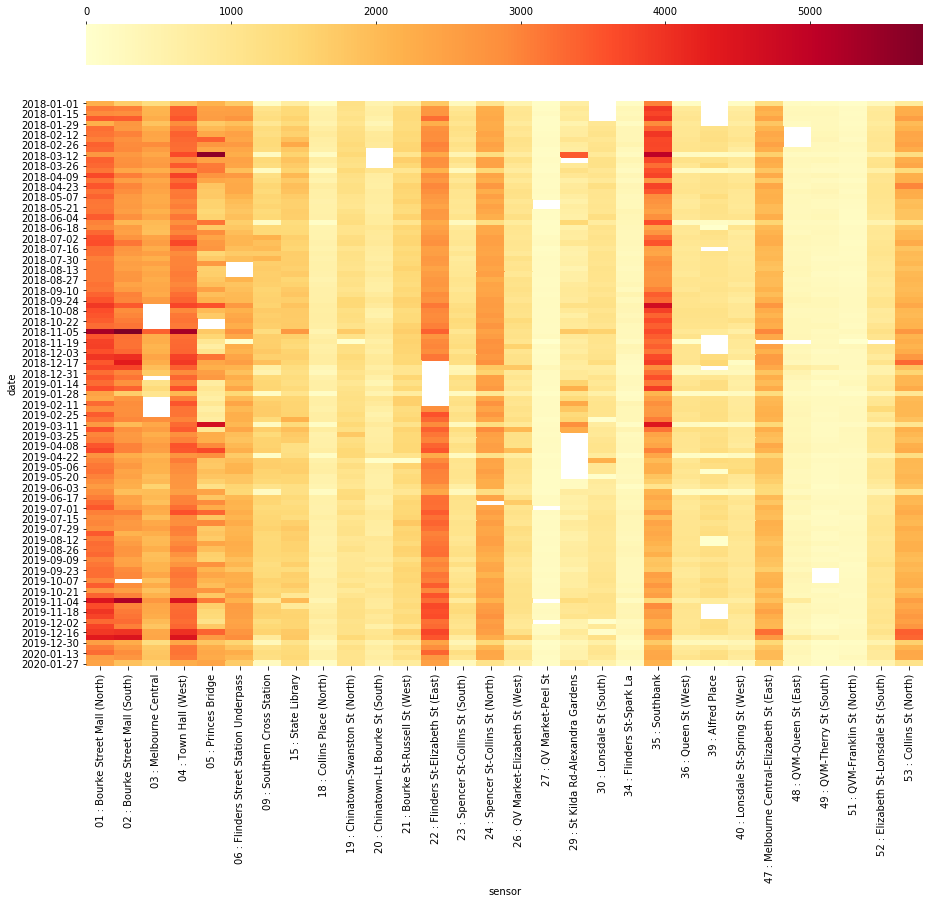

In [252]:
# Visualize training+test sensors for past 2 years
df2 = df[df['sensor_id'].isin(sensors_train_test)]
dfplot2 = df2[df2['year'] >= 2018][['date','sensor','hourly_counts']]

table2 = pd.pivot_table(dfplot2, values='hourly_counts', index='date',
                       columns='sensor', aggfunc=np.sum)

fig, ax = plt.subplots(figsize=(15,13))
ax = sns.heatmap(table2, cbar_kws = dict(use_gridspec=False,location="top"), cmap='YlOrRd')
plt.show()

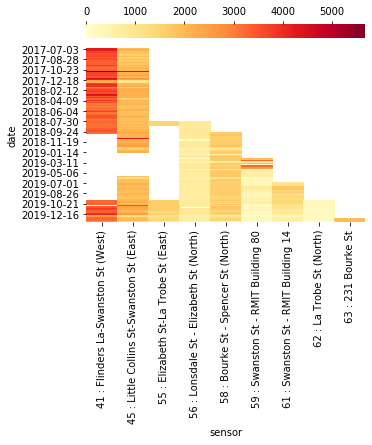

In [253]:
# Visualize test sensors only
df3 = df[df['sensor_id'].isin(sensors_test)]
table3 = pd.pivot_table(df3, values='hourly_counts', index='date',
                       columns='sensor', aggfunc=np.sum)

fig, ax = plt.subplots(figsize=(5,4))
ax = sns.heatmap(table3, cbar_kws = dict(use_gridspec=False,location="top"), cmap='YlOrRd')
plt.show()

In [0]:
# Download all data for shortlisted sensor for last 2 years

# pbar  = progressbar.ProgressBar()
# dfraw = pd.DataFrame(columns=dfraw0.columns)
# years = [2018, 2019, 2020]

# for year in years:
#     for sensor in sensors:
#         results = client.get("b2ak-trbp", sensor_id=sensor, year=year, limit=10000)
#         dfitem = pd.DataFrame.from_records(results)
#         dfraw = pd.concat([dfraw, dfitem])
# dfraw.to_csv('/content/drive/My Drive/Melb_project/sensors_data.csv')
# len(dfraw)

In [0]:
# Open from saved API
dfraw = pd.read_csv('/content/drive/My Drive/Melb_project/sensors_data.csv')
dfraw = dfraw.drop('Unnamed: 0', axis=1)

In [256]:
# Check if no missing datastamps 
a = len(dfraw.date_time.unique())
b = 2*365*24 + 31*24 # num of hours from 01-01-2018 to 31-01-2020
c = sorted(dfraw.date_time.unique())[-1]
print(f'Latest available timestamp in data: {c}')
print(f'Number of unique timestamps in data: {a}')
print(f'Number of expected timestamps: {b}')
print(f'Missing timestamps: {b-a}')

Latest available timestamp in data: 2020-01-31T23:00:00.000
Number of unique timestamps in data: 18264
Number of expected timestamps: 18264
Missing timestamps: 0


# Deal with missing (null) records

In [257]:
# Reshape df into pivot for filling nulls
df0 = dfraw[dfraw['sensor_id'].isin(sensors_train_test)] # exclude test-only sites
df0 = pd.pivot_table(df0, columns='sensor_id',
                     values='hourly_counts',
                     index=['date_time'],
                     aggfunc=np.sum)
display(df0.shape)
display(df0.head(3))

(18264, 30)

sensor_id,1,2,3,4,5,6,9,15,18,19,20,21,22,23,24,26,27,29,30,34,35,36,39,40,47,48,49,51,52,53
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01T00:00:00.000,895.0,734.0,2996.0,3052.0,1757.0,3443.0,1411.0,1709.0,326.0,605.0,431.0,1938.0,2317.0,540.0,1459.0,571.0,181.0,0.0,NaN,943.0,5724.0,685.0,NaN,607.0,1542.0,223.0,264.0,390.0,493.0,1129.0
2018-01-01T01:00:00.000,890.0,590.0,3481.0,3204.0,3900.0,3579.0,436.0,1511.0,118.0,813.0,472.0,2035.0,2158.0,376.0,1426.0,529.0,137.0,814.0,NaN,394.0,5168.0,604.0,NaN,110.0,1227.0,201.0,215.0,134.0,541.0,626.0
2018-01-01T02:00:00.000,435.0,317.0,1721.0,2042.0,2012.0,3157.0,222.0,666.0,64.0,473.0,401.0,1169.0,1305.0,219.0,797.0,286.0,69.0,576.0,NaN,148.0,2495.0,309.0,NaN,65.0,684.0,87.0,116.0,83.0,373.0,226.0


In [258]:
# Check the extent of nan values.
# Total records per sensor_id = 18,284
df0.isna().sum()

sensor_id
1      144
2      240
3     1570
4        0
5      264
6      433
9        0
15       0
18       0
19       0
20     792
21       0
22    1512
23       0
24      72
26      48
27     672
29    1634
30     600
34       0
35       0
36       0
39    2286
40       0
47     108
48     708
49     408
51       0
52     121
53       0
dtype: int64

In [259]:
# Since hourly traffic is very cyclical, copy value from
# the same time and the same day a week ago.

# Number of hours in a week
week_hrs = 7*24

for site in df0.columns:
    for row in range(len(df0.index)):
      # check if hourly record is null
        if math.isnan(df0[site].iloc[row]):
          # if so, copy from the same hour from a week ago
            if row - week_hrs > 0:
                df0[site].iloc[row] = df0[site].iloc[row - week_hrs]
            else:
                # if missing at start of the record:
                df0[site].iloc[row] = df0[site].iloc[row + week_hrs*6]
df0.isna().sum()

sensor_id
1     0
2     0
3     0
4     0
5     0
6     0
9     0
15    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
26    0
27    0
29    0
30    0
34    0
35    0
36    0
39    0
40    0
47    0
48    0
49    0
51    0
52    0
53    0
dtype: int64

In [260]:
# Unstack pivot to double check and prepare to build other columns

df0 = pd.DataFrame(df0.stack())
df0 = df0.rename(columns={0:'hourly_counts'})
df0 = df0.reset_index()
print(f'Number of complete timestamps: {b}')
print(f'Number of df rows: {len(df0)}')
print(f'Number df rows / timestamps = num of sites: {len(df0)/b}')
display(df0.head())

Number of complete timestamps: 18264
Number of df rows: 547920
Number df rows / timestamps = num of sites: 30.0


,date_time,sensor_id,hourly_counts
0,2018-01-01T00:00:00.000,1,895.0
1,2018-01-01T00:00:00.000,2,734.0
2,2018-01-01T00:00:00.000,3,2996.0
3,2018-01-01T00:00:00.000,4,3052.0
4,2018-01-01T00:00:00.000,5,1757.0


In [261]:
# Build complete data frame

'''
Index(['id', 'date_time', 'year', 'month', 'mdate', 'day', 'time', 'sensor_id',
       'sensor_name', 'hourly_counts', 'date', 'week', 'sensor'],
      dtype='object')

'sensor_name', 'sensor'
'''

df = df0.copy()
df['date_time'] = pd.to_datetime(df['date_time']) # format='%Y-%m-%d %H:%M:%S'
df['time']      = df['date_time'].dt.hour
df['mdate']     = df['date_time'].dt.day
df['day']       = df['date_time'].dt.dayofweek
df['week']      = df['date_time'].dt.weekofyear
df['month']     = df['date_time'].dt.month
df['year']      = df['date_time'].dt.year
df['hourly_counts'] = df['hourly_counts'].astype('int')

names_table = sensor_master[['sensor_id', 'sensor_description']].set_index('sensor_id')
names_table = names_table.rename(columns={'sensor_description':'sensor_name'})
df = df.join(names_table, on='sensor_id')
df['sensor'] = (df['sensor_id'].map(lambda row: '0'+str(row)\
                                    if int(row)<10 else row)).astype('str')\
                                     + " : " + df['sensor_name']
display(len(df))
display(sorted(df.date_time.unique())[-1])
display(df.head(3))
display(df.dtypes)

547920

numpy.datetime64('2020-01-31T23:00:00.000000000')

,date_time,sensor_id,hourly_counts,time,mdate,day,week,month,year,sensor_name,sensor
0,2018-01-01,1,895,0,1,0,1,1,2018,Bourke Street Mall (North),01 : Bourke Street Mall (North)
1,2018-01-01,2,734,0,1,0,1,1,2018,Bourke Street Mall (South),02 : Bourke Street Mall (South)
2,2018-01-01,3,2996,0,1,0,1,1,2018,Melbourne Central,03 : Melbourne Central


date_time        datetime64[ns]
sensor_id                 int64
hourly_counts             int64
time                      int64
mdate                     int64
day                       int64
week                      int64
month                     int64
year                      int64
sensor_name              object
sensor                   object
dtype: object

# Investigate variations by location

## 1. Variation by traffic volume

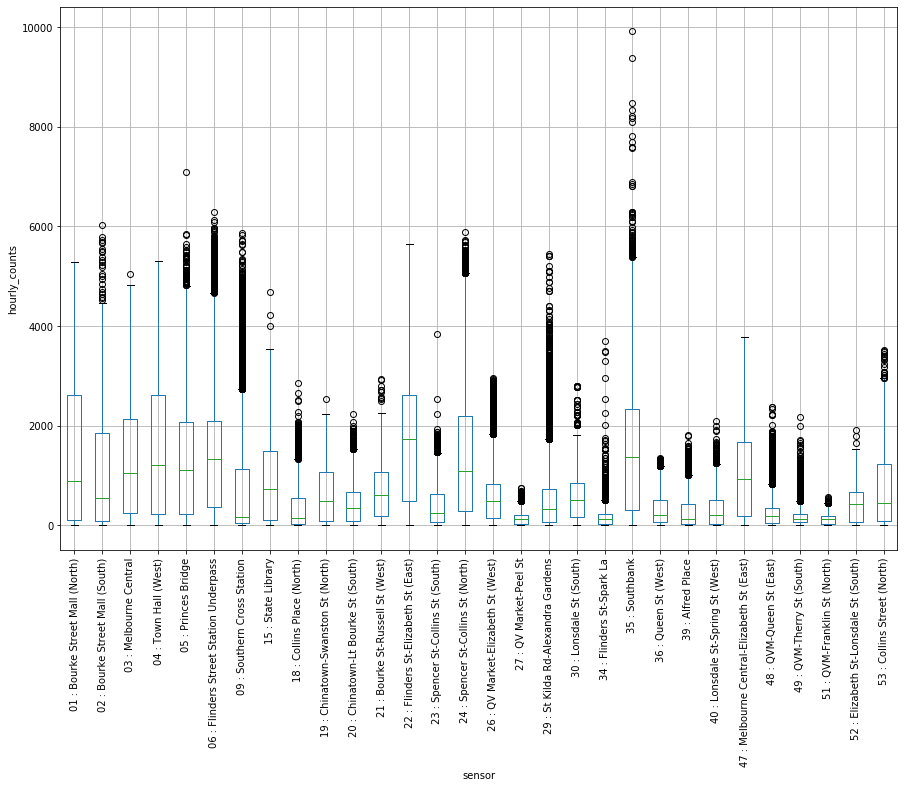

In [262]:
pivotvolume = pd.pivot_table(df, values='hourly_counts',
                             index='date_time', columns='sensor',
                             aggfunc=np.mean)
fig, ax = plt.subplots(figsize=(15,10))
pivotvolume.boxplot(ax=ax)
plt.xticks(rotation=90)
ax.set_xlabel('sensor')
ax.set_ylabel('hourly_counts')
plt.show()

### 2. Variation by hour

In [0]:
# Prepare data for hourly variation
weekdays = df[df['day'] < 5]
weekends = df[df['day'] > 4]

# Part 1
# Normalize data for each sensor
# Weekdays:
pivothour = pd.pivot_table(weekdays, values='hourly_counts',
                           index='time', columns='sensor_id',
                           aggfunc=np.nanmean)
hourcols = pivothour.columns
pivothour = preprocessing.normalize(pivothour, norm='l1', axis=0)
dfhour = pd.DataFrame(pivothour, index=range(0,24), columns=hourcols)
# Weekends:
pivothourW = pd.pivot_table(weekends, values='hourly_counts',
                           index='time', columns='sensor_id',
                           aggfunc=np.nanmean)
hourcolsW = pivothourW.columns
pivothourW = preprocessing.normalize(pivothourW, norm='l1', axis=0)
dfhourW = pd.DataFrame(pivothourW, index=range(0,24), columns=hourcols)

# Part 2
# Normalize data for avg of all sensors
# Weekdays:
pivothour2 = pd.pivot_table(weekdays, values='hourly_counts',
                            index='time', aggfunc=np.nanmean)
dfhour2 = preprocessing.normalize(pivothour2, norm='l1', axis=0)
dfhour2 = pd.DataFrame(dfhour2, index=range(0,24), columns=['all_sensors'])
# Weekends:
pivothour2W = pd.pivot_table(weekends, values='hourly_counts',
                            index='time', aggfunc=np.nanmean)
dfhour2W = preprocessing.normalize(pivothour2W, norm='l1', axis=0)
dfhour2W = pd.DataFrame(dfhour2W, index=range(0,24), columns=['all_sensors'])
# Each of the 7 days
pivothour2E = pd.pivot_table(df, values='hourly_counts', columns='day',
                            index='time', aggfunc=np.nanmean)
dfhour2E = preprocessing.normalize(pivothour2E, norm='l1', axis=0)
dfhour2E = pd.DataFrame(dfhour2E, index=range(0,24), columns=range(0,7))

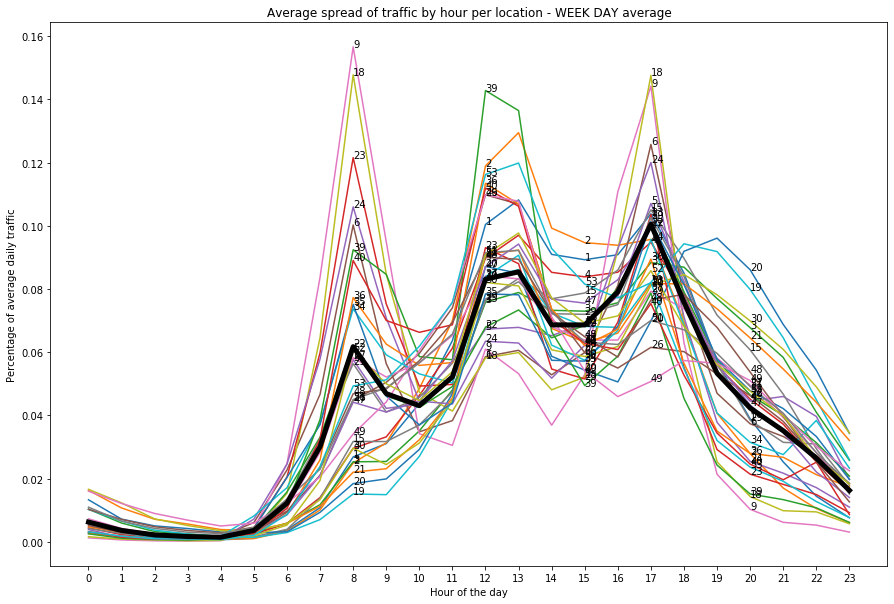

In [264]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(dfhour)
ax.plot(dfhour2, linewidth=5, c='black')

for hour in [8,12,15,17,20]:
    labels = zip(dfhour[dfhour.index == hour].values[0], dfhour.columns)
    for y, label in labels:
        plt.text(hour, y, label, fontsize=10)

ax.set_title('Average spread of traffic by hour per location - WEEK DAY average')
ax.set_ylabel('Percentage of average daily traffic')
ax.set_xlabel('Hour of the day')
ax.set_xticks(range(0,24))
plt.show()

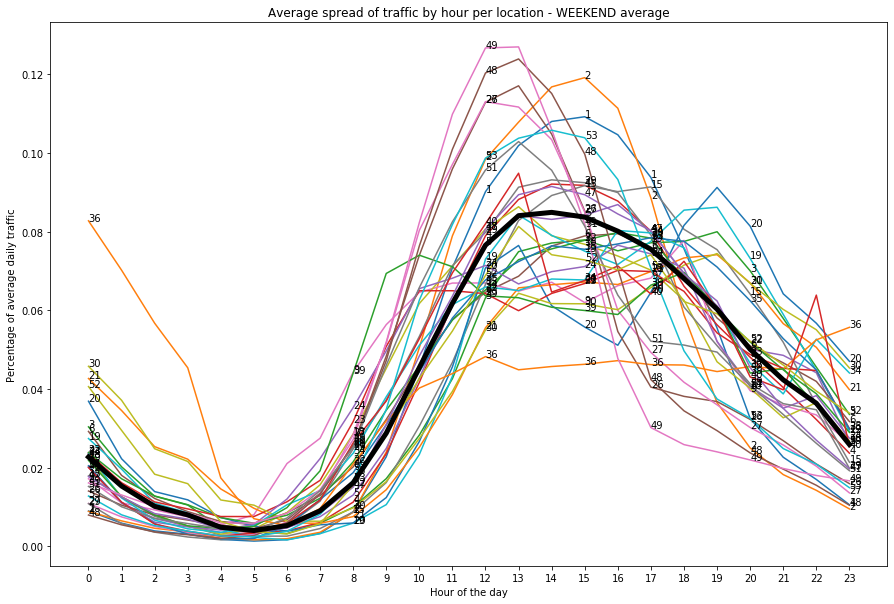

In [265]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(dfhourW)
ax.plot(dfhour2W, linewidth=5, c='black')

for hour in [0,8,12,15,17,20,23]:
    labels = zip(dfhourW[dfhourW.index == hour].values[0], dfhourW.columns)
    for y, label in labels:
        plt.text(hour, y, label, fontsize=10)

ax.set_title('Average spread of traffic by hour per location - WEEKEND average')
ax.set_ylabel('Percentage of average daily traffic')
ax.set_xlabel('Hour of the day')
ax.set_xticks(range(0,24))
plt.show()

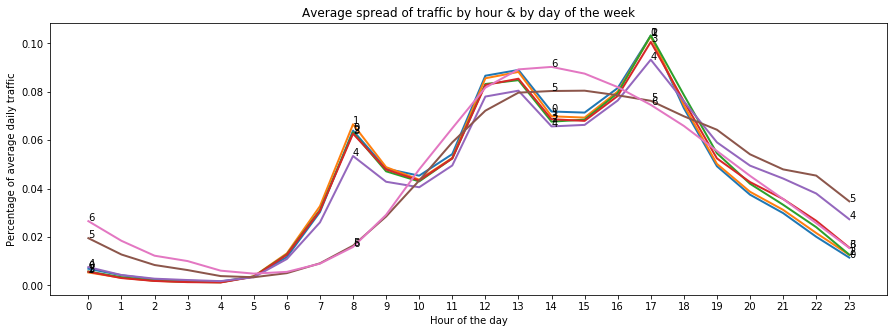

In [266]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(dfhour2E, linewidth=2)

for hour in [0,8,14,17,23]:
    labels = zip(dfhour2E[dfhour2E.index == hour].values[0], dfhour2E.columns)
    for y, label in labels:
        plt.text(hour, y, label, fontsize=10)

ax.set_title('Average spread of traffic by hour & by day of the week')
ax.set_ylabel('Percentage of average daily traffic')
ax.set_xlabel('Hour of the day')
ax.set_xticks(range(0,24))
plt.show()

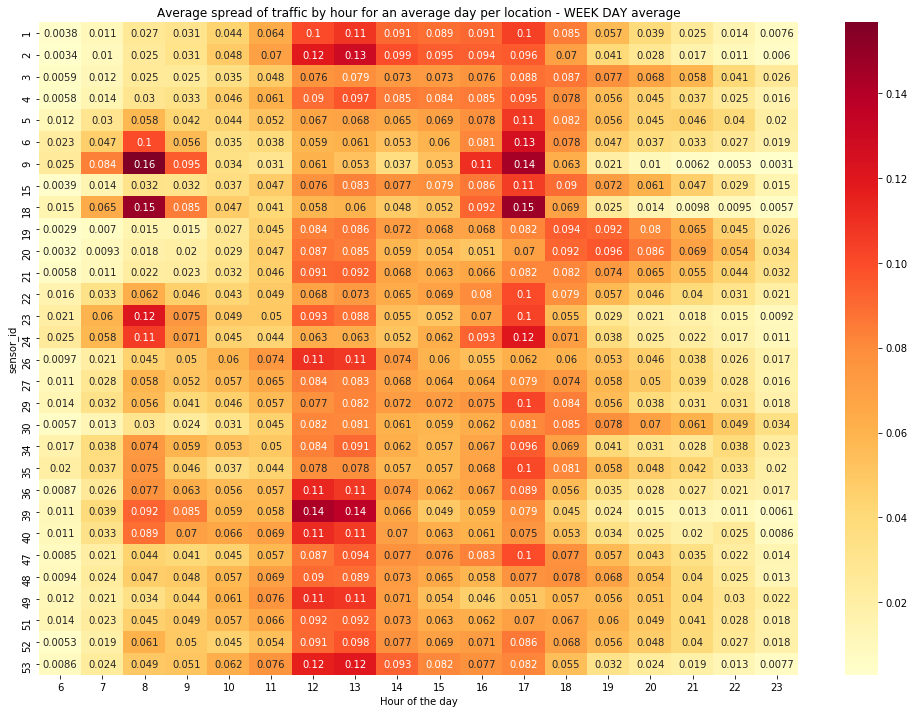

In [267]:
fig, ax = plt.subplots(figsize=(17,12))
sns.heatmap(dfhour[dfhour.index > 5].T, ax=ax, cmap='YlOrRd', annot=True)
ax.set_title('Average spread of traffic by hour for an average day per location - WEEK DAY average')
ax.set_xlabel('Hour of the day')
plt.show()

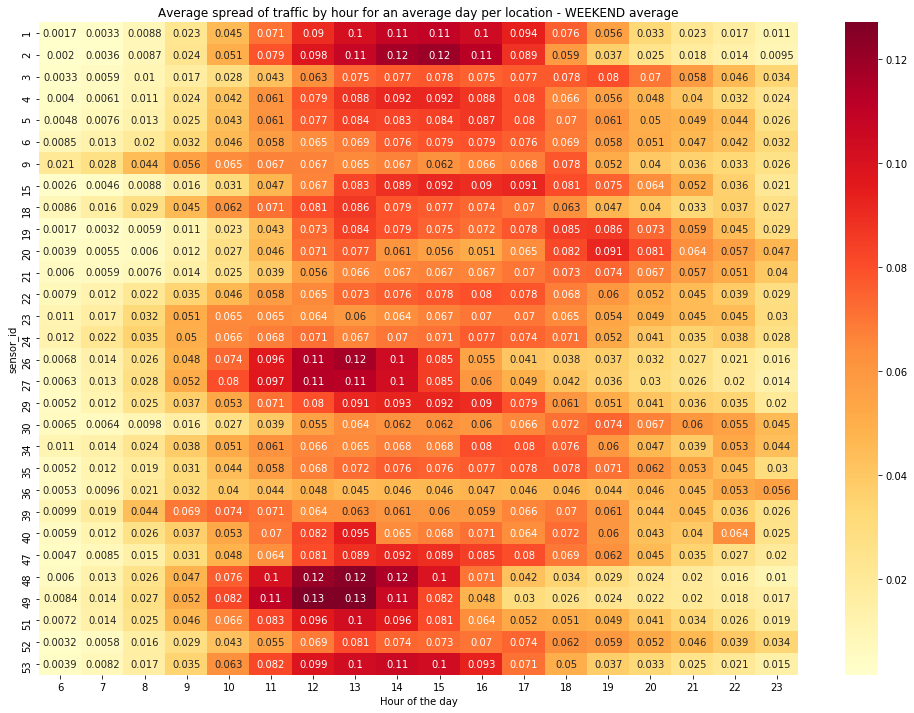

In [268]:
fig, ax = plt.subplots(figsize=(17,12))
sns.heatmap(dfhourW[dfhourW.index > 5].T, ax=ax, cmap='YlOrRd', annot=True)
ax.set_title('Average spread of traffic by hour for an average day per location - WEEKEND average')
ax.set_xlabel('Hour of the day')
plt.show()

#### 3. Variation by week day

In [0]:
# Normalize data for each sensor
pivotweek = pd.pivot_table(df, values='hourly_counts',
                           index='day', columns='sensor_id',
                           aggfunc=np.nanmean)
weekcols = pivotweek.columns
pivotweek = preprocessing.normalize(pivotweek, norm='l1', axis=0)
dfweek = pd.DataFrame(pivotweek, index=range(0,7), columns=weekcols)

# Normalize data for avg of all sensors
pivotweek2 = pd.pivot_table(df, values='hourly_counts',
                            index='day', aggfunc=np.nanmean)
dfweek2 = preprocessing.normalize(pivotweek2, norm='l1', axis=0)
dfweek2 = pd.DataFrame(dfweek2, index=range(0,7), columns=['all_sensors'])

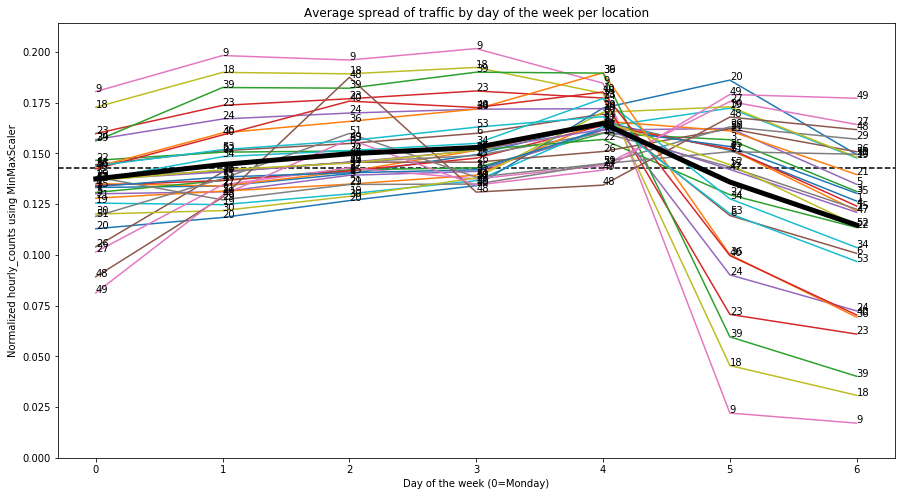

In [270]:
fig, ax = plt.subplots(figsize=(15,8))

ax.hlines(1/7,-0.3,6.3,linestyles='dashed') # if equal spread
ax.plot(dfweek) # actual spread
ax.plot(dfweek2, linewidth=5, c='black')

for day in range(0,7):
    labels = zip(dfweek[dfweek.index == day].values[0], dfweek.columns)
    for y, label in labels:
        plt.text(day, y, label, fontsize=10)

ax.set_title('Average spread of traffic by day of the week per location')
ax.set_ylabel('Normalized hourly_counts using MinMaxScaler')
ax.set_ylim(0,1.5/7)
ax.set_xlim(-0.3,6.3)
ax.set_xlabel('Day of the week (0=Monday)')
plt.show()

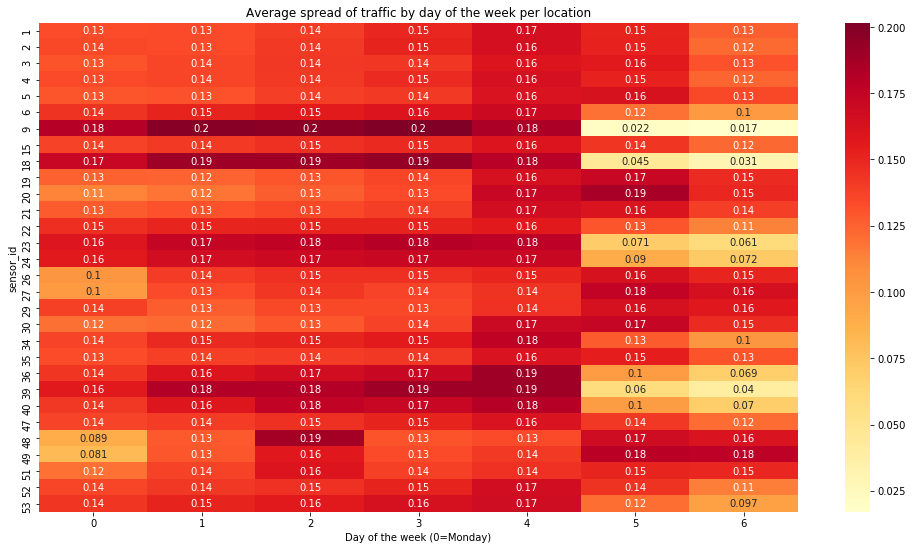

In [271]:
fig, ax = plt.subplots(figsize=(17,9))
sns.heatmap(dfweek.T, ax=ax, cmap='YlOrRd', annot=True)
ax.set_title('Average spread of traffic by day of the week per location')
ax.set_xlabel('Day of the week (0=Monday)')
plt.show()

### 4. Seasonal variation

In [0]:
# Normalize data by sensor
pivotseason = pd.pivot_table(df, values='hourly_counts',
                             index='week', columns='sensor_id',
                             aggfunc=np.nanmean)

nullcols = list((pivotseason.loc[:, pivotseason.isnull().any()]).columns)
dfseason = pivotseason = pivotseason.loc[:, pivotseason.columns.difference(nullcols)]
seasoncols = dfseason.columns
dfseason = preprocessing.normalize(dfseason, norm='l1', axis=0)
dfseason = pd.DataFrame(dfseason, index=range(0,52), columns=seasoncols)

# Normalize data for avg of all sensors
pivotseason2 = pd.pivot_table(df, values='hourly_counts',
                             index='week', aggfunc=np.nanmean)
dfseason2 = preprocessing.normalize(pivotseason2, norm='l1', axis=0)
dfseason2 = pd.DataFrame(dfseason2, index=range(0,52), columns=['all_sensors'])

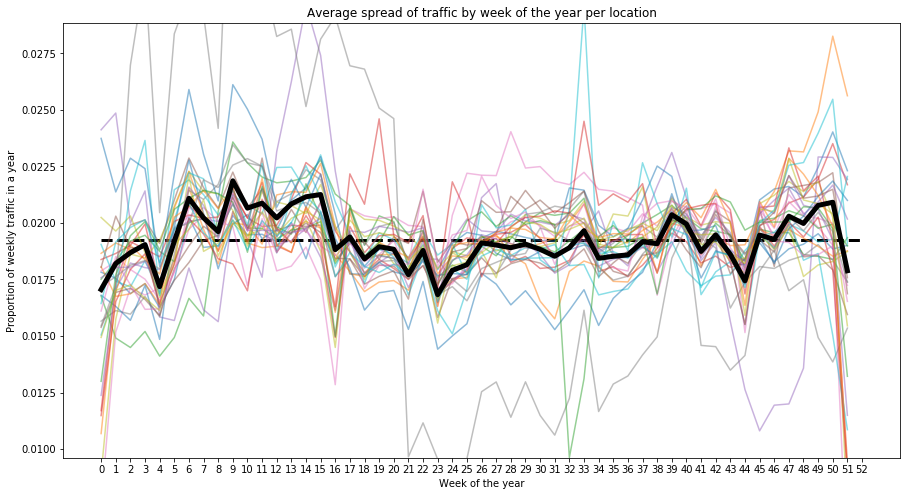

In [273]:
fig, ax = plt.subplots(figsize=(15,8))

ax.hlines(1/52,0,52,linestyles='dashed', linewidth=3) # if equal spread
ax.plot(dfseason, alpha=0.5)
ax.plot(dfseason2, linewidth=5, c='black')

ax.set_title('Average spread of traffic by week of the year per location')
ax.set_ylim(0.5/52,1.5/52)
ax.set_ylabel('Proportion of weekly traffic in a year')
ax.set_xlabel('Week of the year')
ax.set_xticks(range(0,53))
plt.show()

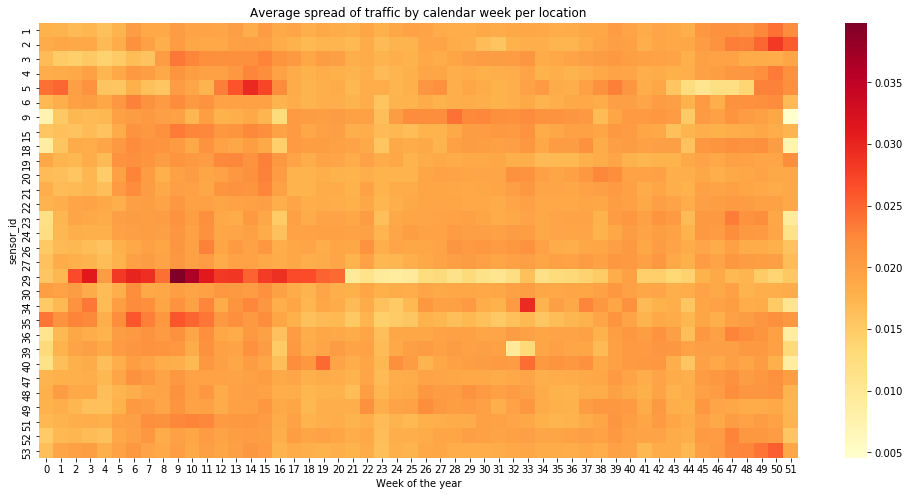

In [274]:
fig, ax = plt.subplots(figsize=(17,8))
sns.heatmap(dfseason.T, ax=ax, cmap='YlOrRd', annot=False)
ax.set_title('Average spread of traffic by calendar week per location')
ax.set_xlabel('Week of the year')
plt.show()

# To do list

~~EDA~~
1. ~~Narrow down sites and period~~
2. ~~Variation by high/low traffic sites~~
3. ~~Variation by hour / day of week / seasons~~

~~Cleansing~~
1. ~~Verify no missing timestamp~~
2. ~~Fill nulls based on general variation rule~~

Assign sites to groups
1. Assign to clusters using EDA results (manual)
2. Use PCA to get better clusters (more data-driven)
3. Drop more sites if needed
4. Restate outliers if needed

Stinky model - ARMA/ARIMA
1. Test for stationarity
2. Differencing
3. PACF, ACF
4. Different model for different cluster

Enhanced models
1. Decision Tree
2. LSTM

Visualisation for end users
1. Static heatmap on city centre map
2. Variable heatmap animation
3. Variable hourly plot animation
4. Web app
